In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
import os.path
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = 15, 12
mpl.rcParams["lines.markeredgewidth"] = 1.0

# Load the necessary files and containing data

In [2]:
#Arduino files -----------------------------------------------------------------------------------------------------
arduino_files = glob.glob("Lightuniformity_Meas/LED5_INT50/HD*.csv")  #Bars on my desk
arduino_files_production = glob.glob("Lightuniformity_Meas/LED5_INT50/In_Production/HD*.csv")  #Bars in production
lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")

for in_production, files in enumerate([arduino_files, arduino_files_production]):
    for filename in files:
        lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
        lightbar_nr = int(lightbar[2:])
        lightbar_dict[lightbar_nr] = { "Arduino_Data" : pd.read_csv(filename, delim_whitespace=True, 
                                                                          comment='#', names=["Ch", "Blue", "Red"]),
                                             "In_Production" : in_production }        

        
        
#Mattest files (optional) ------------------------------------------------------------------------------------------
mattest_files = glob.glob("Lightuniformity_Meas/Mattest/HD*.csv")  #Bars on my desk
mattest_files_production = glob.glob("Lightuniformity_Meas/Mattest/In_Production/HD*.csv")  #Bars in production

for in_production, files in enumerate([mattest_files, mattest_files_production]):
    for filename in files:
        lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
        lightbar_nr = int(lightbar[2:-5])
        led_brightness = int(lightbar[-2:])
        
        if not lightbar_dict.has_key(lightbar_nr):
            raise ValueError("ERROR: Lightbar {} has mattest data but no arduino data!".format(lightbar_nr))
        lightbar_dict[lightbar_nr]["Mattest_Data"] = pd.read_csv(filename, sep=";",  skiprows=15,
                                                                 names=["Ch", "Pedestal", "Gain", "Mean_pixels"])
        lightbar_dict[lightbar_nr]["Mattest_Brightness"] = led_brightness
        
        if lightbar_dict[lightbar_nr]["In_Production"] != in_production:
            print("WARNING: Inconsistency of 'In_Production' value between arduino and mattest data for lightbar {}!"
                  .format(lightbar_nr))

# Calculate mean and other characterics for the different lightbars

In [3]:
for lightbar_nr, data in lightbar_dict.iteritems():
    arduino_data = data["Arduino_Data"]["Red"]
    mattest_data = data["Mattest_Data"]["Mean_pixels"]
    
    arduino_mean = np.mean(arduino_data)
    arduino_std = np.std(arduino_data)
    
    mattest_mean = np.mean(mattest_data)
    mattest_std = np.std(mattest_data)
    
    #Save to dict
    data["Arduino_Mean"] = arduino_mean
    data["Arduino_Rel_Std"] = arduino_std/arduino_mean
    data["Mattest_Mean"] = mattest_mean
    data["Mattest_Rel_Std"] = mattest_std/mattest_mean

# Convert to pandas DataFrame

In [4]:
df = pd.DataFrame(lightbar_dict).transpose()
df["Lightbar"] = df.index
df = df.drop("Arduino_Data", 1)
df = df.drop("Mattest_Data", 1)

df.loc[93]

Arduino_Mean          0.427171
Arduino_Rel_Std       0.192612
In_Production                1
Mattest_Brightness          45
Mattest_Mean           202.051
Mattest_Rel_Std       0.146738
Lightbar                    93
Name: 93, dtype: object

# Plots

### Arduino mean vs. LED brightness of mattest measurement

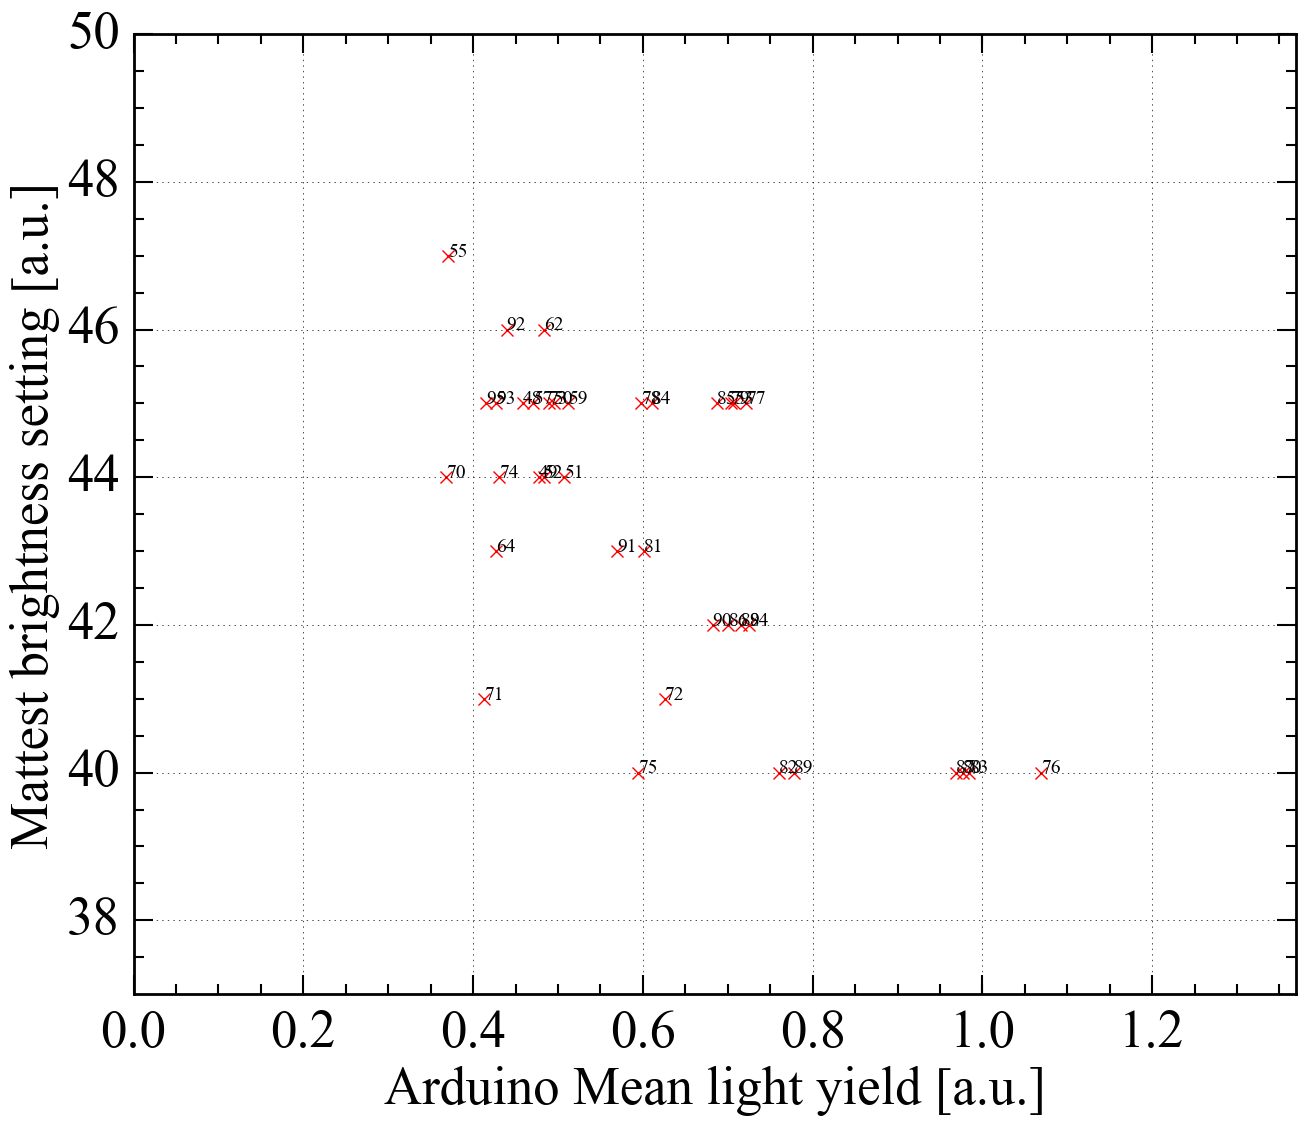

In [5]:
plt.plot( df["Arduino_Mean"], df["Mattest_Brightness"], "rx" )
for x,y, lightbar_nr in df[ ["Arduino_Mean", "Mattest_Brightness", "Lightbar"] ].values:
    plt.text(x,y, lightbar_nr)
plt.minorticks_on()
plt.grid()

plt.xlim(0,max(df["Arduino_Mean"]) + 0.3)
plt.ylim(min(df["Mattest_Brightness"]) - 3, max(df["Mattest_Brightness"]) + 3)
plt.xlabel("Arduino Mean light yield [a.u.]")
plt.ylabel("Mattest brightness setting [a.u.]")

### Arduino rel. std vs. mattest rel. std

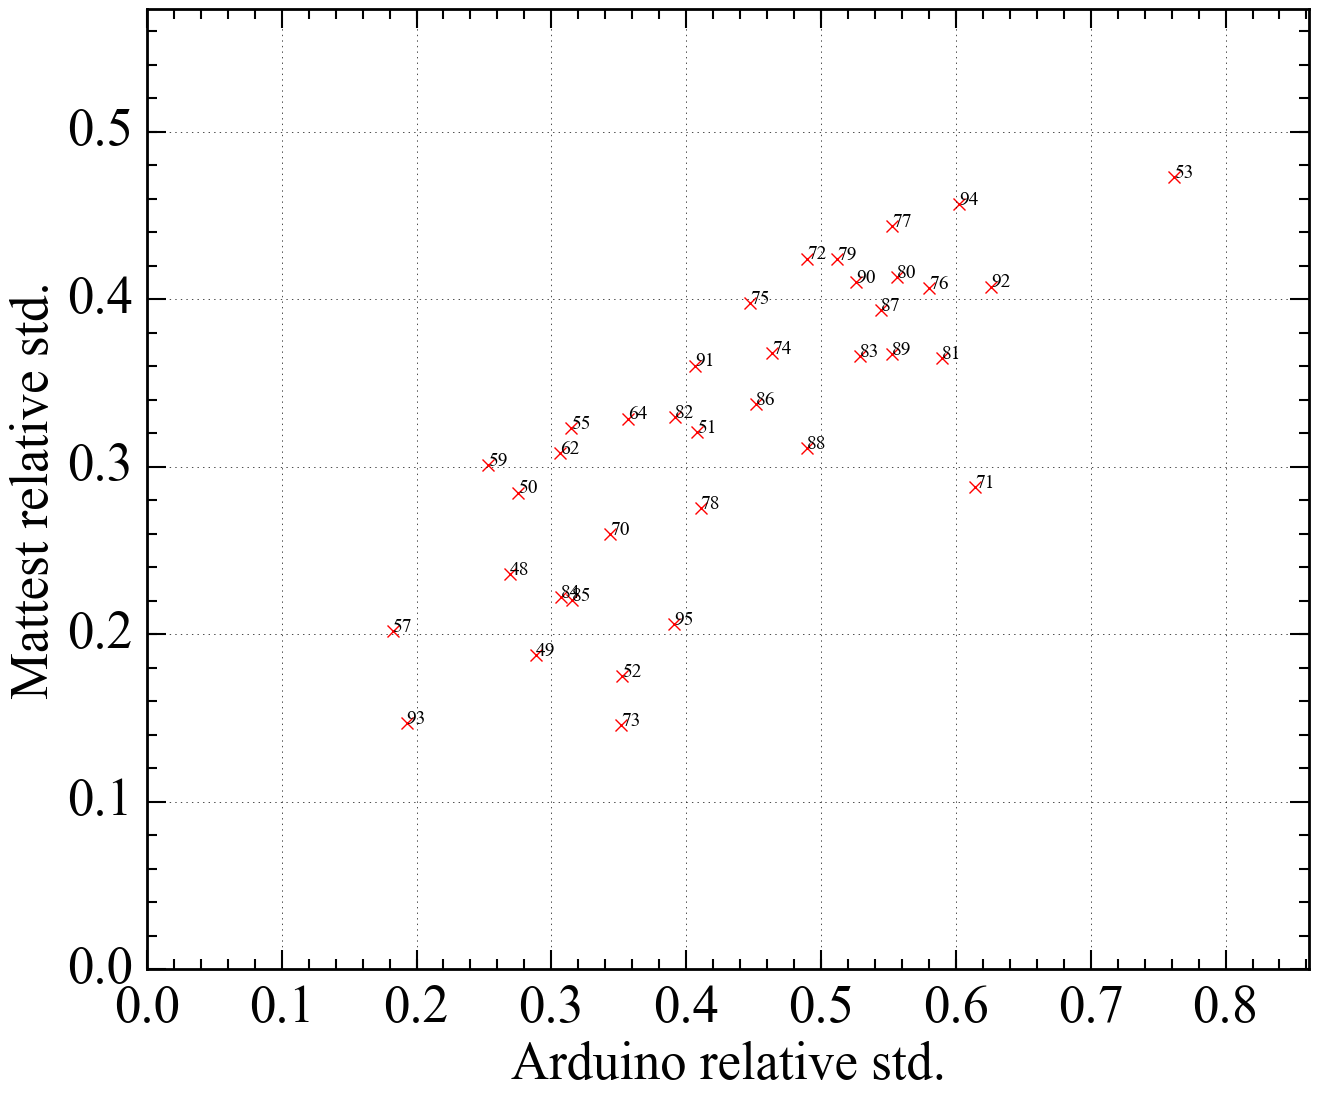

In [6]:
line2d = plt.plot( df["Arduino_Rel_Std"], df["Mattest_Rel_Std"], "rx")[0]
for x,y, lightbar_nr in df[ ["Arduino_Rel_Std", "Mattest_Rel_Std", "Lightbar"] ].values:
    plt.text(x,y, lightbar_nr)

plt.minorticks_on() 
plt.grid()
plt.xlim(0, max(line2d.get_xdata()) + 0.1)
plt.ylim(0, max(line2d.get_ydata()) + 0.1)
plt.xlabel("Arduino relative std.")
plt.ylabel("Mattest relative std.")